**Goal Conditioned Behavior Cloning**

In [25]:
from collections import OrderedDict
import gym
from gym import spaces
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import random
from queue import Queue
from scipy.ndimage import uniform_filter
import copy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
def make_model(input_dim=4, out_dim=2):
  model = Sequential()
  model.add(tf.keras.layers.Dense(10, input_shape=(input_dim,), activation='tanh'))
  model.add(tf.keras.layers.Dense(out_dim, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

  # We expect the model to have four weight variables (a kernel and bias for
  # both layers)
  assert len(model.weights) == 4, 'Model should have 4 weights.'
  return model

In [18]:
model = make_model()
for t in range(20):
  X = np.random.normal(size=(1000, 4))  # some random data
  is_positive = np.sum(X, axis=1) > 0  # A simple binary function
  Y = np.zeros((1000, 2))
  Y[np.arange(1000), is_positive.astype(int)] = 1  # one-hot labels
  history = model.fit(X, Y, epochs=10, batch_size=256, verbose=0)
  loss = history.history['loss'][-1]
  acc = history.history['accuracy'][-1]
  print('(%d) loss= %.3f; accuracy = %.1f%%' % (t, loss, 100 * acc))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(0) loss= 0.633; accuracy = 64.6%
(1) loss= 0.504; accuracy = 79.4%
(2) loss= 0.413; accuracy = 85.1%
(3) loss= 0.355; accuracy = 90.1%
(4) loss= 0.295; accuracy = 92.8%
(5) loss= 0.259; accuracy = 94.7%
(6) loss= 0.227; accuracy = 95.2%
(7) loss= 0.205; accuracy = 96.9%
(8) loss= 0.181; accuracy = 96.7%
(9) loss= 0.169; accuracy = 97.1%
(10) loss= 0.152; accuracy = 99.0%
(11) loss= 0.153; accuracy = 97.7%
(12) loss= 0.141; accuracy = 98.3%
(13) loss= 0.116; accuracy = 99.0%
(14) loss= 0.107; accuracy = 99.3%
(15) loss= 0.113; accuracy = 99.2%
(16) loss= 0.089; accuracy = 99.2%
(17) loss= 0.092; accuracy = 99.2%
(18) loss= 0.086; accuracy = 99.4%
(19) loss= 0.085; accuracy = 99.3%


**Build toy environments for sanity check (Four rooms environment)**

The vector of scalar action `a` is defined as `self.act_set[a]`. The dynamics is to attempt to move current position `self.s` towards the next position by *adding* the action vector unless the next position is the wall. The reward is constant zero and not used in this problem.

The episode will end in the two scenarios:
- next position is exactly the goal: success
- time is over `self.t == self.T`: failure




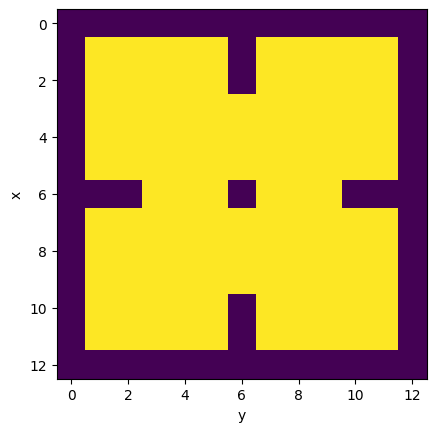

In [7]:
### 2.1 Build Goal-Conditioned Task
class FourRooms:
	def __init__(self, l=5, T=30):
		'''
		FourRooms Environment for pedagogic purposes
		Each room is a l*l square gridworld,
		connected by four narrow corridors,
		the center is at (l+1, l+1).
		There are two kinds of walls:
		- borders: x = 0 and 2*l+2 and y = 0 and 2*l+2
		- central walls
		T: maximum horizion of one episode should be larger than O(4*l)
		'''
		assert l % 2 == 1 and l >= 5
		self.l = l
		self.total_l = 2 * l + 3
		self.T = T

		# create a map: zeros (walls) and ones (valid grids)
		self.map = np.ones((self.total_l, self.total_l), dtype=bool)
		# build walls
		self.map[0, :] = self.map[-1, :] = self.map[:, 0] = self.map[:, -1] = False
		self.map[l+1, [1,2,-3,-2]] = self.map[[1,2,-3,-2], l+1] = False
		self.map[l+1, l+1] = False

		# define action mapping (go right/up/left/down, counter-clockwise)
		# e.g [1, 0] means + 1 in x coordinate, no change in y coordinate hence
		# hence resulting in moving right
		self.act_set = np.array([
			[1, 0], [0, 1], [-1, 0], [0, -1]
		], dtype=int)
		self.action_space = spaces.Discrete(4)

		# you may use self.act_map in search algorithm
		self.act_map = {}
		self.act_map[(1, 0)] = 0
		self.act_map[(0, 1)] = 1
		self.act_map[(-1, 0)] = 2
		self.act_map[(0, -1)] = 3

	def render_map(self):
		plt.imshow(self.map)
		plt.xlabel('y')
		plt.ylabel('x')
		plt.savefig('p2_map.png',
					bbox_inches='tight', pad_inches=0.1, dpi=300)
		plt.show()

	def sample_sg(self):
		# sample s
		while True:
			s = [np.random.randint(self.total_l),
				np.random.randint(self.total_l)]
			if self.map[s[0], s[1]]:
				break

		# sample g
		while True:
			g = [np.random.randint(self.total_l),
				np.random.randint(self.total_l)]
			if self.map[g[0], g[1]] and \
				(s[0] != g[0] or s[1] != g[1]):
				break
		return s, g

	def reset(self, s=None, g=None):
		'''
		s: starting position, np.array((2,))
		g: goal, np.array((2,))
		return obs: np.cat(s, g)
		'''
		if s is None or g is None:
			s, g = self.sample_sg()
		else:
			assert 0 < s[0] < self.total_l - 1 and 0 < s[1] < self.total_l - 1
			assert 0 < g[0] < self.total_l - 1 and 0 < g[1] < self.total_l - 1
			assert (s[0] != g[0] or s[1] != g[1])
			assert self.map[s[0], s[1]] and self.map[g[0], g[1]]

		self.s = s
		self.g = g
		self.t = 1

		return self._obs()

	def step(self, a):
		'''
		a: action, a scalar
		return obs, reward, done, info
		- done: whether the state has reached the goal
		- info: succ if the state has reached the goal, fail otherwise
		'''
		assert self.action_space.contains(a)

		# WRITE CODE HERE
		done = False
		info = "fail"
		self.t += 1
		action = self.act_set[a]
		next = self.s + action
		if self.map[next[0], next[1]]:
			# valid location
			self.s = next
			if next[0] == self.g[0] and next[1] == self.g[1]:
				done = True
				info = "succ"
		if (self.t == self.T):
			done = True
		# END
		return self._obs(), 0.0, done, info

	def _obs(self):
		return np.concatenate([self.s, self.g])

# build env
l, T = 5, 30
env = FourRooms(l, T)
### Visualize the map
env.render_map()

**Shortest-path search algorithm**

In [12]:

N = 1000
#N = 2
expert_trajs = []
expert_actions = []

for run in range(N):
  s, g = env.sample_sg()
  s = np.array(s)
  g = np.array(g)
  #env.reset(s, g)
  size = 2*l + 2
  visited = [[False for j in range(size)] for i in range(size)]
  states = [[-1 for j in range(size)] for i in range(size)]
  q = Queue(maxsize = size ** 2)
  q.put((s, -1))
  visited[s[0]][s[1]] = True
  while not q.empty():
    (point, prev_action) = q.get()

    states[point[0]][point[1]] = prev_action
    if point[0] == g[0] and point[1] == g[1]:
      break
    for a in range(4):
      action = env.act_set[a]
      new_point = point + action
      if env.map[new_point[0], new_point[1]] and not visited[new_point[0]][new_point[1]]:
        q.put((new_point, a))
        visited[new_point[0]][new_point[1]] = True
  expert_traj = []
  expert_action = []
  point = g
  expert_traj.append(np.concatenate([g, g]))
  expert_action.append(0) # last action does not matter
  while (point[0] != s[0] or point[1] != s[1]):
    a = states[point[0]][point[1]]
    expert_action.append(a)
    point = point - env.act_set[a]
    expert_traj.append(np.concatenate([point, g]))

  expert_traj.reverse()
  expert_action.reverse()
  expert_traj = np.array(expert_traj)
  expert_action = np.array(expert_action)
  expert_trajs.append(expert_traj)
  expert_actions.append(expert_action)

plot a subset of expert trajectories

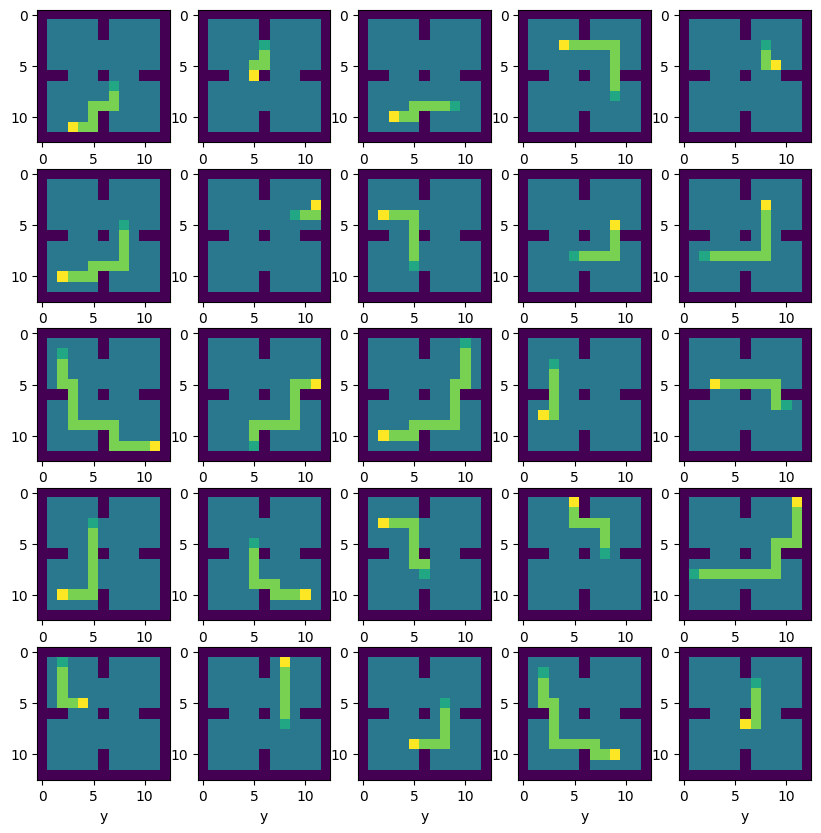

In [13]:
plt.style.use('default')

fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = axes.reshape(-1)
for idx, ax in enumerate(axes):
  plot_traj(env, ax, expert_trajs[idx])

plt.savefig('p2_expert_trajs.png',
		 bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

**Train Goal-Conditioned Policy via Behavior Cloning**

In [22]:
def action_to_one_hot(env, action):
    action_vec = np.zeros(env.action_space.n)
    action_vec[action] = 1
    return action_vec

def relabel_trajectory(trajectory, actions):
	# trajectory: [len, 4]
	# actions: [len]
	new_trajectory = []
	new_actions = []
	for i in range(1, len(trajectory)):
		# relabel for (0, i)
		trajectory_segment = [t for t in trajectory[:i]]
		action_segment = [a for a in actions[:i]]
		new_goal = trajectory[i]
		for j in range(0, i):
			trajectory_segment[j][2] = new_goal[0]
			trajectory_segment[j][3] = new_goal[1]
		new_trajectory.extend(copy.deepcopy(trajectory_segment))
		new_actions.extend(action_segment)
	return new_trajectory, new_actions

class GCBC:

	def __init__(self, env, expert_trajs, expert_actions, goals=None):
		self.env = env
		self.expert_trajs = expert_trajs
		self.expert_actions = expert_actions
		self.transition_num = sum(map(len, expert_actions))
		self.model = make_model(input_dim=4, out_dim=4)
		# state_dim + goal_dim = 4
		# action_choices = 4

	def reset_model(self):
		self.model = make_model(input_dim=4, out_dim=4)

	def generate_behavior_cloning_data(self):
		# 3 you will use action_to_one_hot() to convert scalar to vector
		# state should include goal
		self._train_states = []
		self._train_actions = []

		self._train_states = np.concatenate(self.expert_trajs)
		self._train_actions = np.concatenate(self.expert_actions)
		self._train_actions = [action_to_one_hot(self.env, action) for action in self._train_actions]


		self._train_states = np.array(self._train_states).astype(float) # size: (*, 4)
		self._train_actions = np.array(self._train_actions) # size: (*, 4)

	def generate_relabel_data(self):
		# apply expert relabelling trick
		self._train_states = []
		self._train_actions = []


		for i in range(len(self.expert_trajs)):
			new_trajectory, new_actions = relabel_trajectory(self.expert_trajs[i], self.expert_actions[i])
			self._train_states.extend(new_trajectory)
			self._train_actions.extend(new_actions)
		self._train_actions = [action_to_one_hot(self.env, action) for action in self._train_actions]

		self._train_states = np.array(self._train_states).astype(float) # size: (*, 4)
		self._train_actions = np.array(self._train_actions) # size: (*, 4)

	def train(self, num_epochs=20, batch_size=256):
		"""
		  num_epochs: number of epochs to train on the data generated by the expert.
			batch_size
		Return:
		  loss: (float) final loss of the trained policy.
		  acc: (float) final accuracy of the trained policy
		"""
		history = self.model.fit(self._train_states, self._train_actions, epochs=num_epochs, batch_size=batch_size, verbose=0)
		loss = history.history['loss'][-1]
		acc = history.history['accuracy'][-1]
		return loss, acc

# new_trajectory, new_actions = \
	relabel_trajectory([[1, 1, 3, 3], [1, 2, 3, 3], [1, 3, 3, 3], [2, 3, 3, 3], [3, 3, 3, 3]],
                   [1, 1, 2, 2, 0])
# print(new_trajectory)
# print(new_actions)

Implement evaluation function



In [23]:
def evaluate_gc(env, policy, n_episodes=50):
	succs = 0
	for _ in range(n_episodes):
		info = generate_gc_episode(env, policy)
		# WRITE CODE HERE
		if info == "succ":
			succs += 1
		# END
	succs /= n_episodes
	return succs

def generate_gc_episode(env, policy):
	"""
	Collects one rollout from the policy in an environment
	Args:
		env: an OpenAI Gym environment.
		policy: a keras model
	Returns:
	"""
	done = False
	state = env.reset()
	while not done:
		# WRITE CODE HERE
		# prev_state = state
		action_vec = policy.model(np.expand_dims(state, axis=0)) # (1, 4)
		action = tf.math.argmax(action_vec[0]).numpy()
		state, _, done, info = env.step(action)
		# print(prev_state, env.act_set[action])
		# END
	return info


Test GCBC using vanilla mode vs GCBC with expert relabeling trick mode


In [ ]:
# mode = 'vanilla'
mode = 'relabel'

In [ ]:
gcbc = GCBC(env, expert_trajs, expert_actions)
if mode == 'vanilla':
	gcbc.generate_behavior_cloning_data()
else:
	gcbc.generate_relabel_data()

print(gcbc._train_states.shape)

num_seeds = 3
loss_vecs = []
acc_vecs = []
succ_vecs = []

for i in range(num_seeds):
	print('*' * 50)
	print('seed: %d' % i)
	loss_vec = []
	acc_vec = []
	succ_vec = []
	gcbc.reset_model()

	for e in range(200):
		loss, acc = gcbc.train(num_epochs=20)
		succ = evaluate_gc(env, gcbc)
		loss_vec.append(loss)
		acc_vec.append(acc)
		succ_vec.append(succ)
		print(e, round(loss,3), round(acc,3), succ)
	loss_vecs.append(loss_vec)
	acc_vecs.append(acc_vec)
	succ_vecs.append(succ_vec)

loss_vec = np.mean(np.array(loss_vecs), axis = 0).tolist()
acc_vec = np.mean(np.array(acc_vecs), axis = 0).tolist()
succ_vec = np.mean(np.array(succ_vecs), axis = 0).tolist()


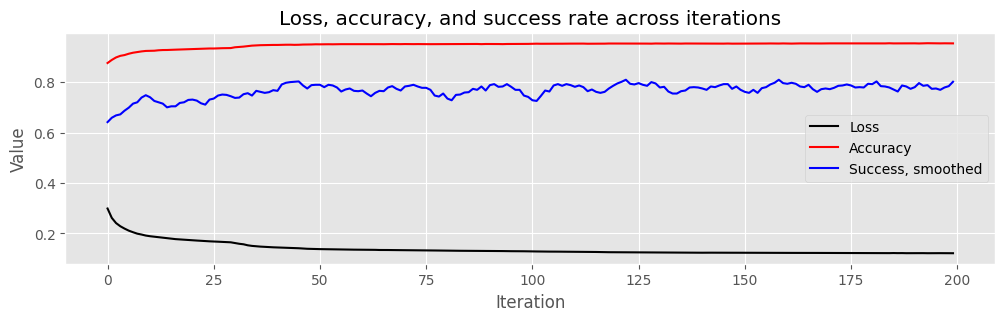

In [ ]:
### Plot the results
plt.figure(figsize=(12, 3))
plt.style.use('ggplot')
plt.plot(loss_vec, color='black', label="Loss")
plt.plot(acc_vec, color='red', label="Accuracy")
plt.plot(uniform_filter(succ_vec, 5), color='blue', label="Success, smoothed")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Loss, accuracy, and success rate across iterations")
plt.legend()
plt.savefig('p2_gcbc_%s.png' % mode, dpi=300)
plt.show()